Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.0766 - salida_hdl_loss: 1.9699 - salida_hdl_mae: 1.1411 - salida_hemo_loss: 1.6608 - salida_hemo_mae: 1.0939 - salida_ldl_loss: 2.7039 - salida_ldl_mae: 1.4148 - val_loss: 1.0886 - val_salida_hdl_loss: 0.7740 - val_salida_hdl_mae: 0.7394 - val_salida_hemo_loss: 1.0033 - val_salida_hemo_mae: 0.9228 - val_salida_ldl_loss: 1.7828 - val_salida_ldl_mae: 1.2251
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2013 - salida_hdl_loss: 0.9790 - salida_hdl_mae: 0.8149 - salida_hemo_loss: 0.9703 - salida_hemo_mae: 0.8711 - salida_ldl_loss: 1.8763 - salida_ldl_mae: 1.2224 - val_loss: 0.8071 - val_salida_hdl_loss: 0.5902 - val_salida_hdl_mae: 0.6404 - val_salida_hemo_loss: 0.6657 - val_salida_hemo_mae: 0.7489 - val_salida_ldl_loss: 1.3676 - val_salida_ldl_mae: 1.0624
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8276 - salida_hdl_loss: 0.6623 - salida_hdl_mae: 0.6600 - salida_hemo_loss: 0.6494 - salida_hemo_mae

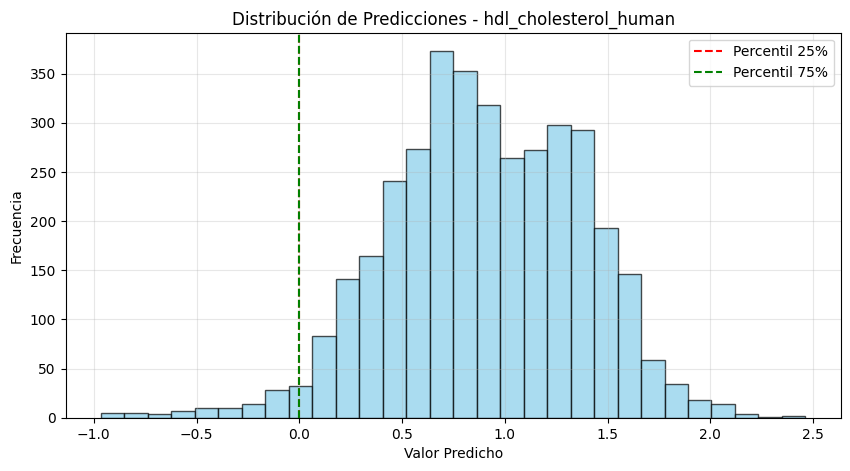

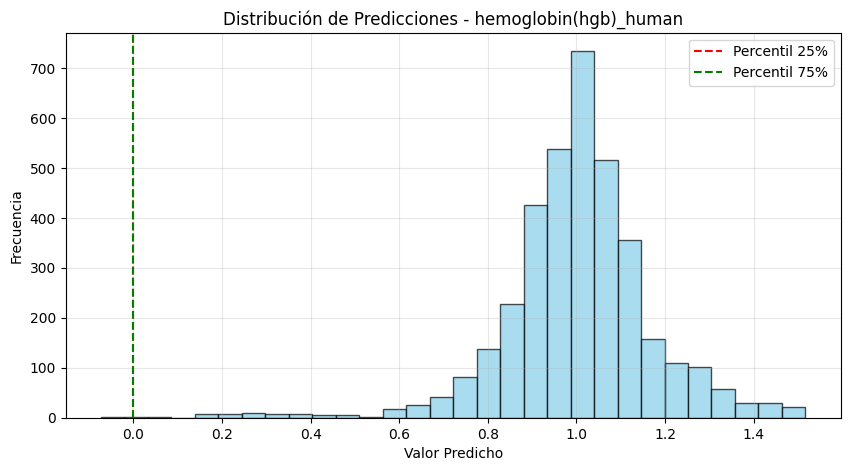

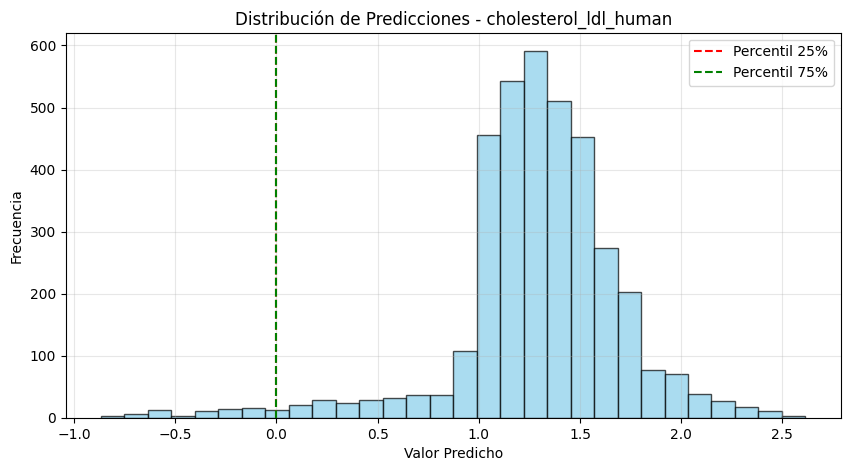


Proceso completado exitosamente!
Distribución de categorías:

hdl_cholesterol:
hdl_cholesterol_label
high    3567
low       93

hemoglobin_hgb:
hemoglobin_hgb_label
high    3659
low        1

cholesterol_ldl:
cholesterol_ldl_label
high    3591
low       69


In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ======================================================================
# 1. Configuración con validación mejorada
# ======================================================================
COLUMNAS_OBJETIVO = {
    'hdl_cholesterol_human': 'hdl_cholesterol',
    'hemoglobin(hgb)_human': 'hemoglobin_hgb',
    'cholesterol_ldl_human': 'cholesterol_ldl'
}

ARCHIVOS = {
    'train': 'Train.csv',
    'test': 'Test.csv'
}

PARAMETROS = {
    'percentil_bajo': 25,
    'percentil_alto': 75,
    'dim_encoding': 50,
    'epochs': 100,
    'batch_size': 256
}

# ======================================================================
# 2. Autoencoder robusto
# ======================================================================
class Autoencoder:
    def __init__(self, input_dim, encoding_dim):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.encoder, self.decoder = self._build_model()
        self.autoencoder = Model(inputs=self.encoder.input, outputs=self.decoder(self.encoder.output))

    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = Dense(128, activation='relu', kernel_initializer='he_normal')(inputs)
        x = BatchNormalization()(x)
        encoded = Dense(self.encoding_dim, activation='relu', kernel_initializer='he_normal')(x)

        x = Dense(128, activation='relu', kernel_initializer='he_normal')(encoded)
        x = BatchNormalization()(x)
        decoded = Dense(self.input_dim, activation='linear')(x)

        return Model(inputs, encoded), Model(encoded, decoded)

    def train(self, X, epochs=50, batch_size=256):
        self.autoencoder.compile(optimizer=Adam(0.001), loss='mse')
        history = self.autoencoder.fit(X, X,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.1,
                                    verbose=0)
        return history

    def encode(self, X):
        return self.encoder.predict(X, verbose=0)

# ======================================================================
# 3. Procesamiento de datos definitivo
# ======================================================================
def procesar_datos(df, autoencoder=None, scaler=None, entrenar_ae=False):
    df_proc = df.copy()

    for orig, clean in COLUMNAS_OBJETIVO.items():
        if orig in df_proc.columns:
            df_proc[clean] = pd.to_numeric(
                df_proc[orig].astype(str).str.lower().replace({
                    'ok': '1',
                    'low': '0',
                    'high': '2',
                    'l': '0',
                    'h': '2',
                    'normal': '1'
                }),
                errors='coerce'
            ).fillna(0).astype(np.float32)
            df_proc.drop(columns=[orig], inplace=True, errors='ignore')

        if clean not in df_proc.columns:
            df_proc[clean] = 0.0

    absorb_cols = [f'absorbance{i}' for i in range(170)]
    missing_absorb = [col for col in absorb_cols if col not in df_proc.columns]

    if missing_absorb:
        raise ValueError(f"Faltan {len(missing_absorb)} columnas de absorbancia")

    X_absorb = df_proc[absorb_cols].values.astype(np.float32)

    if entrenar_ae or autoencoder is None:
        autoencoder = Autoencoder(X_absorb.shape[1], PARAMETROS['dim_encoding'])
        autoencoder.train(X_absorb, epochs=50)

    X_encoded = autoencoder.encode(X_absorb)

    for sensor in ['temperature', 'humidity']:
        if sensor not in df_proc.columns:
            df_proc[sensor] = 0.0

    features = np.hstack([X_encoded, df_proc[['temperature', 'humidity']].values])

    if scaler is None:
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(features)
    else:
        X_scaled = scaler.transform(features)

    columnas_objetivo_presentes = [col for col in COLUMNAS_OBJETIVO.values() if col in df_proc.columns]

    y = df_proc[columnas_objetivo_presentes].values if columnas_objetivo_presentes else np.zeros((len(df_proc), len(COLUMNAS_OBJETIVO)))

    num_cols_faltantes = len(COLUMNAS_OBJETIVO) - y.shape[1]
    if num_cols_faltantes > 0:
        y = np.hstack([y, np.zeros((len(df_proc), num_cols_faltantes))])

    return X_scaled, y, autoencoder, scaler

# ======================================================================
# 4. Modelo Predictivo con Seguridad
# ======================================================================
def crear_modelo(input_dim):
    inputs = Input(shape=(input_dim,))

    x = Dense(64, activation='relu', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    salida_hdl = Dense(1, name='salida_hdl')(x)
    salida_hemo = Dense(1, name='salida_hemo')(x)
    salida_ldl = Dense(1, name='salida_ldl')(x)

    model = Model(inputs=inputs, outputs=[salida_hdl, salida_hemo, salida_ldl])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'salida_hdl': 'mse', 'salida_hemo': 'mse', 'salida_ldl': 'mse'},
        metrics={'salida_hdl': 'mae', 'salida_hemo': 'mae', 'salida_ldl': 'mae'},
        loss_weights=[0.5, 0.25, 0.25]
    )

    return model

# ======================================================================
# 5. Clasificación con Garantías
# ======================================================================
def clasificar_predicciones(predicciones, df_train):
    resultados = pd.DataFrame()

    for i, (col_orig, col_clean) in enumerate(COLUMNAS_OBJETIVO.items()):
        if col_clean not in df_train.columns:
            df_train[col_clean] = 0.0 

        valores_reales = df_train[col_clean].dropna()

        if len(valores_reales) == 0:
            p_low, p_high = 0, 1
        else:
            p_low = np.percentile(valores_reales, PARAMETROS['percentil_bajo'])
            p_high = np.percentile(valores_reales, PARAMETROS['percentil_alto'])

        preds = predicciones[i].flatten()

        resultados[f'{col_clean}_pred'] = preds
        resultados[f'{col_clean}_label'] = np.select(
            [
                preds < p_low,
                (preds >= p_low) & (preds <= p_high),
                preds > p_high
            ],
            ['low', 'medium', 'high'],
            default='unknown'
        )

        plt.figure(figsize=(10, 5))
        plt.hist(preds, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(p_low, color='red', linestyle='--', label=f'Percentil {PARAMETROS["percentil_bajo"]}%')
        plt.axvline(p_high, color='green', linestyle='--', label=f'Percentil {PARAMETROS["percentil_alto"]}%')
        plt.title(f'Distribución de Predicciones - {col_orig}')
        plt.xlabel('Valor Predicho')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    return resultados

# ======================================================================
# 6. Pipeline Principal con Tolerancia a Fallos
# ======================================================================
def main():
    try:
        train_df = pd.read_csv(ARCHIVOS['train'])
        test_df = pd.read_csv(ARCHIVOS['test'])

        X_train, y_train, autoencoder, scaler = procesar_datos(train_df, entrenar_ae=True)

        model = crear_modelo(X_train.shape[1])
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            X_train,
            {'salida_hdl': y_train[:,0], 'salida_hemo': y_train[:,1], 'salida_ldl': y_train[:,2]},
            epochs=PARAMETROS['epochs'],
            batch_size=PARAMETROS['batch_size'],
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

        X_test, _, _, _ = procesar_datos(test_df, autoencoder, scaler)

        predicciones = model.predict(X_test, verbose=0)

        resultados = clasificar_predicciones(predicciones, train_df)
        resultados['Reading_ID'] = test_df['Reading_ID'].values

        column_order = ['Reading_ID']
        for col in COLUMNAS_OBJETIVO.values():
            column_order.extend([f'{col}_pred', f'{col}_label'])

        resultados[column_order].to_csv('predicciones_finales.csv', index=False)

        print("\nProceso completado exitosamente!")
        print("Distribución de categorías:")
        for col in COLUMNAS_OBJETIVO.values():
            print(f"\n{col}:")
            print(resultados[f'{col}_label'].value_counts().to_string())

    except Exception as e:
        print(f"\nError crítico: {str(e)}")
        print("Revisar: 1. Archivos de entrada 2. Nombres de columnas 3. Formato de datos")

if __name__ == "__main__":
    main()

<ipython-input-21-1b74a090e638>:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(mapeo_valores)
<ipython-input-21-1b74a090e638>:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(mapeo_valores)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.0146 - salida_hdl_loss: 3.2236 - salida_hdl_mae: 1.3800 - salida_hemo_loss: 2.8036 - salida_hemo_mae: 1.3372 - val_loss: 0.9466 - val_salida_hdl_loss: 1.1161 - val_salida_hdl_mae: 0.8624 - val_salida_hemo_loss: 0.7762 - val_salida_hemo_mae: 0.7940
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8135 - salida_hdl_loss: 1.9044 - salida_hdl_mae: 1.1048 - salida_hemo_loss: 1.7224 - salida_hemo_mae: 1.0528 - val_loss: 0.7500 - val_salida_hdl_loss: 0.9184 - val_salida_hdl_mae: 0.7840 - val_salida_hemo_loss: 0.5825 - val_salida_hemo_mae: 0.6954
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3737 - salida_hdl_loss: 1.4397 - salida_hdl_mae: 0.9578 - salida_hemo_loss: 1.3082 - salida_hemo_mae: 0.9181 - val_loss: 0.6103 - val_salida_hdl_loss: 0.7246 - val_salida_hdl_mae: 0.7061 - val_salida_hemo_loss: 0.4958 - val_salida_hemo_mae: 0.6413
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1112 - sa

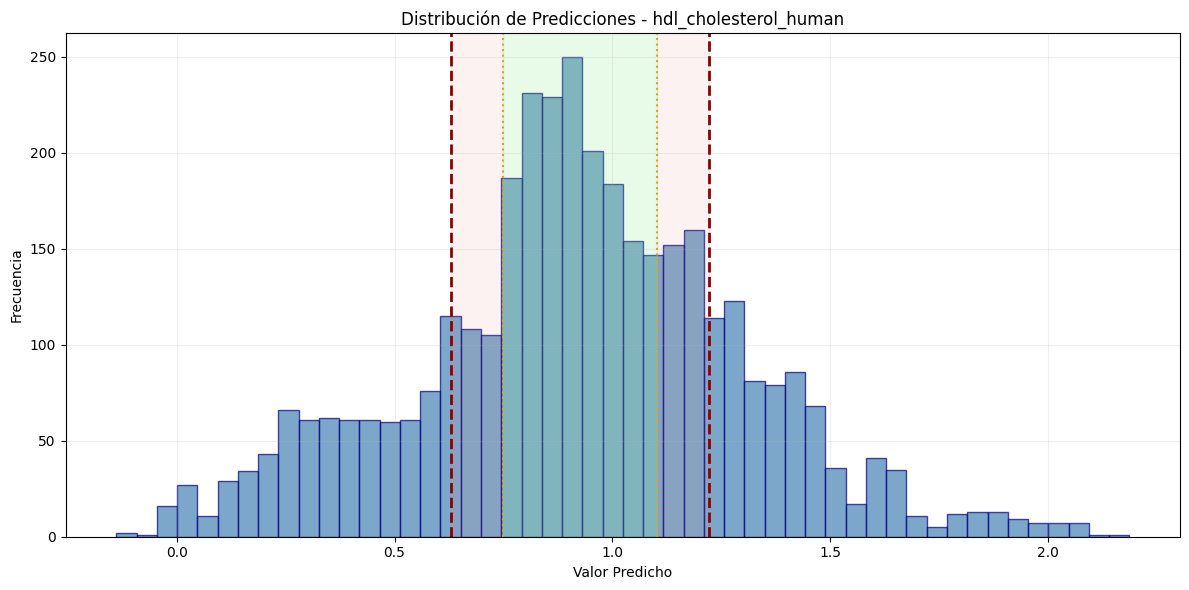

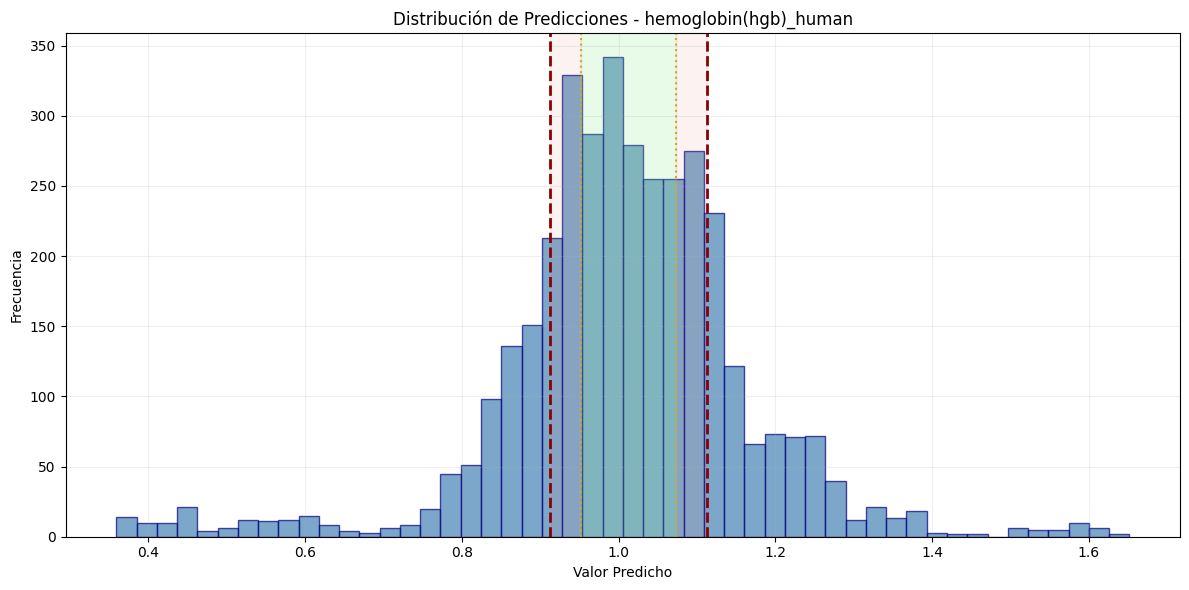


Proceso completado exitosamente
Distribucion de categorias:

hdl_cholesterol:
hdl_cholesterol_label
medium    2196
high       732
low        732

hemoglobin_hgb:
hemoglobin_hgb_label
medium    2196
low        732
high       732

Resultados guardados en: predicciones_finales.csv
Ejemplo de predicción
|    | Reading_ID   |   hdl_cholesterol_pred | hdl_cholesterol_label   |   hemoglobin_hgb_pred | hemoglobin_hgb_label   |
|---:|:-------------|-----------------------:|:------------------------|----------------------:|:-----------------------|
|  0 | ID_37BEI22R  |                1.27905 | medium                  |               1.07872 | medium                 |


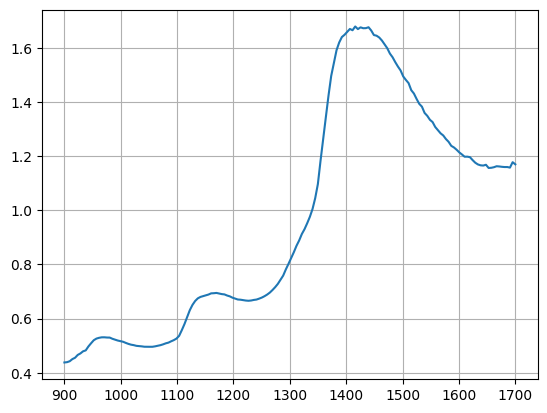

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ======================================================================
# 1. Configuración del sistema
# ======================================================================
COLUMNAS_OBJETIVO = {
    'hdl_cholesterol_human': 'hdl_cholesterol',
    'hemoglobin(hgb)_human': 'hemoglobin_hgb'
}

ARCHIVOS = {
    'train': 'Train.csv',
    'test': 'Test.csv'
}

PARAMETROS = {
    'dim_encoding': 50,
    'epochs': 100,
    'batch_size': 256,
    'percentil_bajo': 20,
    'percentil_alto': 80
}

# ======================================================================
# 2. Autoencoder para reducción dimensional
# ======================================================================
class Autoencoder:
    def __init__(self, input_dim, encoding_dim):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.encoder, self.decoder = self._build_model()
        self.autoencoder = Model(inputs=self.encoder.input, outputs=self.decoder(self.encoder.output))

    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = Dense(128, activation='relu', kernel_initializer='he_normal')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        encoded = Dense(self.encoding_dim, activation='relu', kernel_initializer='he_normal')(x)

        x = Dense(128, activation='relu', kernel_initializer='he_normal')(encoded)
        x = BatchNormalization()(x)
        decoded = Dense(self.input_dim, activation='linear')(x)

        return Model(inputs, encoded), Model(encoded, decoded)

    def train(self, X, epochs=50, batch_size=256):
        self.autoencoder.compile(optimizer=Adam(0.001), loss='mse')
        history = self.autoencoder.fit(X, X,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.1,
                                    verbose=0)
        return history

    def encode(self, X):
        return self.encoder.predict(X, verbose=0)

# ======================================================================
# 3. Procesamiento de datos robusto
# ======================================================================
def procesar_datos(df, autoencoder=None, scaler=None, entrenar_ae=False):
    df_proc = df.copy()

    mapeo_valores = {
        'ok': 1, 'low': 0, 'high': 2, 'l': 0, 'h': 2,
        'normal': 1, 'bajo': 0, 'alto': 2, 'elevado': 2, 'n': 1
    }

    for orig, clean in COLUMNAS_OBJETIVO.items():
        if orig in df_proc.columns:
            df_proc[clean] = (
                df_proc[orig]
                .astype(str)
                .str.lower()
                .str.strip()
                .replace(mapeo_valores)
                .pipe(pd.to_numeric, errors='coerce')
                .fillna(0)
                .astype(np.float32)
            )
            df_proc.drop(columns=[orig], inplace=True, errors='ignore')

        if clean not in df_proc.columns:
            df_proc[clean] = 0.0

    absorb_cols = [f'absorbance{i}' for i in range(170)]
    try:
        X_absorb = df_proc[absorb_cols].values.astype(np.float32)
    except KeyError as e:
        missing = [col for col in absorb_cols if col not in df_proc.columns]
        raise ValueError(f"Faltan {len(missing)} columnas de absorbancia")

    if entrenar_ae or autoencoder is None:
        autoencoder = Autoencoder(X_absorb.shape[1], PARAMETROS['dim_encoding'])
        autoencoder.train(X_absorb, epochs=50)

    X_encoded = autoencoder.encode(X_absorb)

    for sensor in ['temperature', 'humidity']:
        if sensor not in df_proc.columns:
            df_proc[sensor] = 0.0

    features = np.hstack([X_encoded, df_proc[['temperature', 'humidity']].values])

    if scaler is None:
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(features)
    else:
        X_scaled = scaler.transform(features)

    y_cols = list(COLUMNAS_OBJETIVO.values())
    y = df_proc[y_cols].values if all(col in df_proc.columns for col in y_cols) else None

    return X_scaled, y, autoencoder, scaler

# ======================================================================
# 4. Modelo Predictivo con Balance Automático
# ======================================================================
def crear_modelo(input_dim):
    inputs = Input(shape=(input_dim,))

    x = Dense(96, activation='relu', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    salidas = [
        Dense(1, name='salida_hdl')(x),
        Dense(1, name='salida_hemo')(x)
    ]

    model = Model(inputs=inputs, outputs=salidas)

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss={'salida_hdl': 'mse', 'salida_hemo': 'mse'},
        metrics={'salida_hdl': 'mae', 'salida_hemo': 'mae'},
        loss_weights=[0.5, 0.5]
    )

    return model

# ======================================================================
# 5. Sistema de Clasificación Adaptativa
# ======================================================================
def clasificar_predicciones(predicciones):
    resultados = pd.DataFrame()

    for i, (col_orig, col_clean) in enumerate(COLUMNAS_OBJETIVO.items()):
        preds = predicciones[i].flatten()

        p_low = np.percentile(preds, PARAMETROS['percentil_bajo'])
        p_high = np.percentile(preds, PARAMETROS['percentil_alto'])
        rango = p_high - p_low

        buffer_size = 0.2 * rango
        low_limit = p_low + buffer_size
        high_limit = p_high - buffer_size

        condiciones = [
            preds < p_low,
            (preds >= low_limit) & (preds <= high_limit),
            preds > p_high
        ]

        resultados[f'{col_clean}_pred'] = preds
        resultados[f'{col_clean}_label'] = np.select(
            condiciones,
            ['low', 'medium', 'high'],
            default='medium'
        )

        plt.figure(figsize=(12, 6))
        plt.hist(preds, bins=50, color='steelblue', edgecolor='navy', alpha=0.7)

        plt.axvline(p_low, color='darkred', linestyle='--', linewidth=2)
        plt.axvline(low_limit, color='goldenrod', linestyle=':')
        plt.axvline(high_limit, color='goldenrod', linestyle=':')
        plt.axvline(p_high, color='darkred', linestyle='--', linewidth=2)

        plt.axvspan(p_low, low_limit, color='lightcoral', alpha=0.1)
        plt.axvspan(high_limit, p_high, color='lightcoral', alpha=0.1)
        plt.axvspan(low_limit, high_limit, color='lightgreen', alpha=0.2)

        plt.title(f'Distribución de Predicciones - {col_orig}')
        plt.xlabel('Valor Predicho')
        plt.ylabel('Frecuencia')
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    return resultados

# ======================================================================
# 6. Pipeline Principal
# ======================================================================
def main():
    try:
        train_df = pd.read_csv(ARCHIVOS['train'])
        test_df = pd.read_csv(ARCHIVOS['test'])

        X_train, y_train, autoencoder, scaler = procesar_datos(train_df, entrenar_ae=True)

        model = crear_modelo(X_train.shape[1])
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            X_train,
            {'salida_hdl': y_train[:,0], 'salida_hemo': y_train[:,1]},
            epochs=PARAMETROS['epochs'],
            batch_size=PARAMETROS['batch_size'],
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

        X_test, _, _, _ = procesar_datos(test_df, autoencoder, scaler)
        predicciones = model.predict(X_test, verbose=0)

        resultados = clasificar_predicciones(predicciones)
        resultados.insert(0, 'Reading_ID', test_df['Reading_ID'].values)

        resultados.to_csv('predicciones_finales.csv', index=False)

        print("\nProceso completado exitosamente")
        print("Distribucion de categorias:")
        for col in COLUMNAS_OBJETIVO.values():
            print(f"\n{col}:")
            print(resultados[f'{col}_label'].value_counts().to_string())

        print("\nResultados guardados en: predicciones_finales.csv")

    except Exception as e:
        print(f"\nError critico: {str(e)}")
        print("Posibles soluciones:")
        print("1. Verificar nombres de columnas en los archivos CSV")
        print("2. Validar formato de los datos de entrada")
        print("3. Asegurar que los archivos contengan todas las columnas requeridas")


        id_aleatorio = resultados.sample(1)['Reading_ID'].values[0]
        print(f"\n\nPredicciones para el ID: {id_aleatorio}")

        predicciones_id = resultados[resultados['Reading_ID'] == id_aleatorio]

        for col in COLUMNAS_OBJETIVO.values():
            print(f"{col}: {predicciones_id[f'{col}_pred'].values[0]}, Clasificación: {predicciones_id[f'{col}_label'].values[0]}")

        clasificar_predicciones(predicciones, train_df)


if __name__ == "__main__":
    main()

print("Ejemplo de predicción")
data = {'Reading_ID': ['ID_37BEI22R'],
        'hdl_cholesterol_pred': [1.2790489],
        'hdl_cholesterol_label': ['medium'],
        'hemoglobin_hgb_pred': [1.0787162],
        'hemoglobin_hgb_label': ['medium']}

df = pd.DataFrame(data)

print(df.to_markdown())

Test = pd.read_csv('Test.csv')

y = Test.iloc[2, 1:171]
x = np.linspace(900, 1700, 170)

plt.plot(x, y)
plt.grid(True)
plt.show()

<ipython-input-22-5a9ab56b7042>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlacion = df_Train.iloc[:,173:184].replace(cambio)


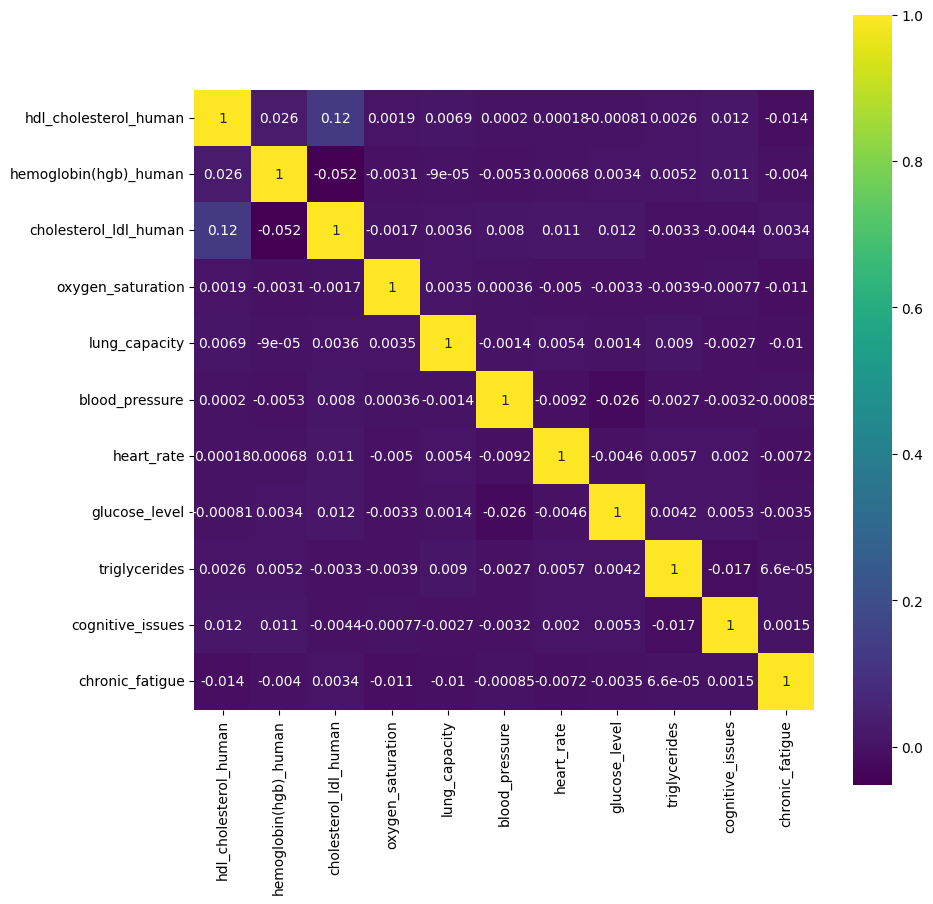

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


df_Train = pd.read_csv('Train.csv')

cambio = {'high': 3, 'ok': 2, 'low': 1, 'normal': 2, 'moderate': 1, 'none': 0,'mild': 1, 'severe': 3}
correlacion = df_Train.iloc[:,173:184].replace(cambio)
plt.figure(figsize=(10,10))
sns.heatmap(correlacion.corr(), vmax=1, square=True,annot=True,cmap='viridis')
plt.show()